In [ ]:
# Importing neccessary libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve, LearningCurveDisplay
from nltk.corpus import stopwords
nltk.download('stopwords')
# Setting seed for reproducibility
SEED = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Loading data
data = pd.read_csv('phishing_email.csv')
print(data.head())
print(data.info())
# 'text_combined' column for email content and 'label' column for phishing status.

                                       text_combined  label
0  hpl nom may 25 2001 see attached file hplno 52...    0.0
1  nom actual vols 24 th forwarded sabrae zajac h...    0.0
2  enron actuals march 30 april 1 201 estimated a...    0.0
3  hpl nom may 30 2001 see attached file hplno 53...    0.0
4  hpl nom june 1 2001 see attached file hplno 60...    0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82797 entries, 0 to 82796
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text_combined  82797 non-null  object 
 1   label          82486 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.3+ MB
None


In [ ]:
# Preprocessing

# filling missing email content and drop rows missing a label.
data['text_combined'] = data['text_combined'].fillna('')
data.dropna(subset=['label'], inplace=True)
data.drop_duplicates(inplace=True)

# Advanced text preprocessing using regex and stopword removal
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)            # Remove text in square brackets
    text = re.sub('@\w+\s*', '', text)             # Remove mentions
    text = re.sub("\\W", " ", text)                # Remove non-word characters
    text = re.sub('https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub('http', '', text)
    text = re.sub('<.*?>+', '', text)              # Remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub('\n', '', text)                  # Remove newlines
    text = re.sub('\w*\d\w*', '', text)             # Remove words containing numbers
    text = re.sub(r'[\U0001F600-\U0001F64F'
                  r'\U0001F300-\U0001F5FF'
                  r'\U0001F680-\U0001F6FF'
                  r'\U0001F1E0-\U0001F1FF]', '', text)  # Remove emojis
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text

def delete_one_characters(text):
    # Remove single character words
    deleted = [word for word in text.split() if len(word) > 1]
    final_text = ' '.join(deleted)
    return final_text
print("Data shape:", data.shape)


Data shape: (82078, 2)


In [ ]:
# Applying preprocessing creating a new column.
data['clean_text'] = data['text_combined'] \
    .apply(clean_text) \
    .apply(drop_stopwords) \
    .apply(delete_one_characters)

print("\nPreprocessed Data:")
print(data[['text_combined', 'clean_text']].head())


Preprocessed Data:
                                       text_combined  \
0  hpl nom may 25 2001 see attached file hplno 52...   
1  nom actual vols 24 th forwarded sabrae zajac h...   
2  enron actuals march 30 april 1 201 estimated a...   
3  hpl nom may 30 2001 see attached file hplno 53...   
4  hpl nom june 1 2001 see attached file hplno 60...   

                                          clean_text  
0  hpl nom may see attached file hplno xls hplno xls  
1  nom actual vols th forwarded sabrae zajac hou ...  
2  enron actuals march april estimated actuals ma...  
3  hpl nom may see attached file hplno xls hplno xls  
4  hpl nom june see attached file hplno xls hplno...  


In [ ]:
# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(data['clean_text']).toarray()
# Encode labels for supervised learning (labels become y)
le = LabelEncoder()
y = le.fit_transform(data['label'])

In [ ]:
# Unsupervised Learning: dimensionality reduction and clustering
pca = PCA(n_components=50, random_state=SEED)
X_pca = pca.fit_transform(X_text)
# Apply KMeans clustering
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
cluster_labels = kmeans.fit_predict(X_pca)
data['cluster'] = cluster_labels
# Combine Features: append cluster label

X_combined = np.hstack([X_text, cluster_labels.reshape(-1, 1)])


In [ ]:
# Split the dataset for supervised learning (80/20 train-test split)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=SEED)
print("\nTraining data shape:", X_train.shape)
print("Test data shape:", X_test.shape)



Training data shape: (65662, 1001)
Test data shape: (16416, 1001)


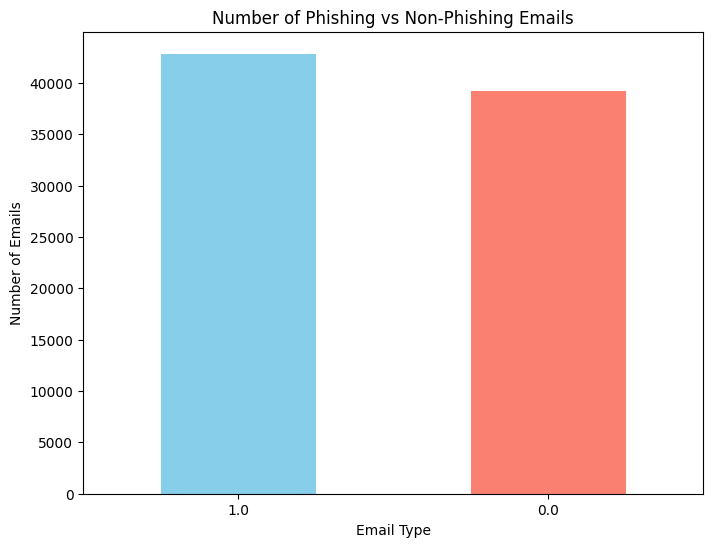


Label distribution:
label
1.0    42845
0.0    39233
Name: count, dtype: int64


In [ ]:
# Plot the number of phishing vs non-phishing emails
label_counts = data['label'].value_counts()
# Creating bar plot
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Email Type')
plt.ylabel('Number of Emails')
plt.title('Number of Phishing vs Non-Phishing Emails')
plt.xticks(rotation=0)
plt.show()
print("\nLabel distribution:")
print(label_counts)


In [ ]:
# Supervised Learning: building logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=SEED)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("\nAccuracy:", accuracy)
print("Mean Squared Error:", mse)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.963754873294347
Mean Squared Error: 0.036245126705653025

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7910
           1       0.96      0.97      0.97      8506

    accuracy                           0.96     16416
   macro avg       0.96      0.96      0.96     16416
weighted avg       0.96      0.96      0.96     16416



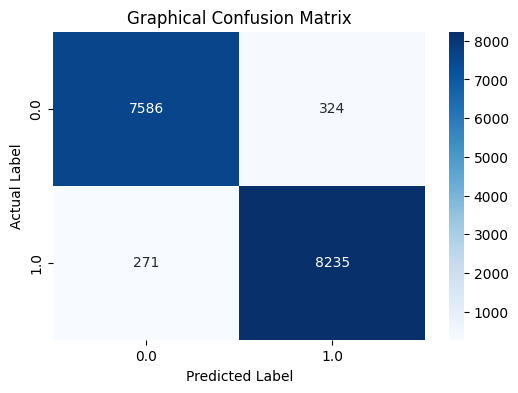

In [ ]:
# Compute the confusion matrix from predictions
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Graphical Confusion Matrix")
plt.show()

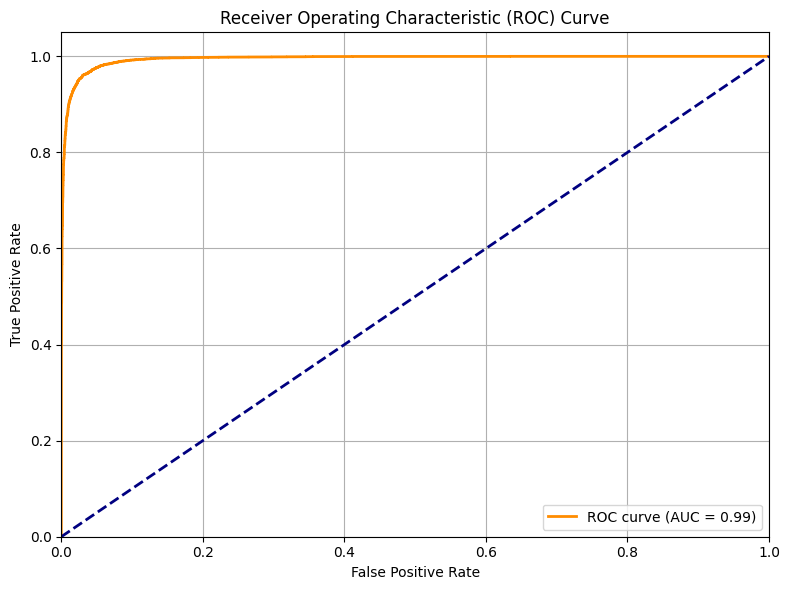

Area Under the Curve (AUC): 0.9944520236031799


In [ ]:
# Predict probabilities instead of class labels
y_proba = clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print AUC value
print("Area Under the Curve (AUC):", roc_auc)


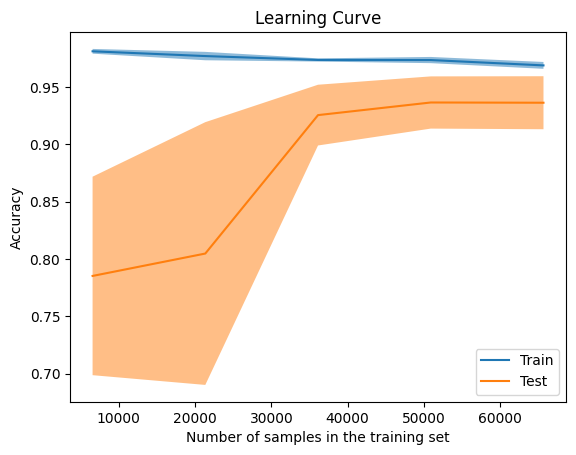

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 5)
lcd = LearningCurveDisplay.from_estimator(
    clf, X_combined, y,
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED
)
lcd.ax_.set_title("Learning Curve")
plt.show()


In [ ]:
def predict_email(raw_text):
    """ Predict whether a single email is phishing (label=1) or safe (label=0) """
    # 1. Preprocess
    cleaned = clean_text(raw_text)
    no_sw   = drop_stopwords(cleaned)
    final   = delete_one_characters(no_sw)

    # 2. Vectorize with TF‑IDF
    x_tfidf = tfidf.transform([final]).toarray()

    # 3. Get cluster label
    x_pca    = pca.transform(x_tfidf)
    cluster  = kmeans.predict(x_pca).reshape(-1, 1)

    # 4. Combine features
    x_combined = np.hstack([x_tfidf, cluster])

    # 5. Predict
    y_pred = clf.predict(x_combined)[0]

    # 6. Decode back to original label
    return le.inverse_transform([y_pred])[0]

# Example usage:
if __name__ == "__main__":
    while True:
        print("\nType/paste an email (click Enter to quit):")
        email = input().strip()
        if not email:
            break
        print("→ This email is classified as:", predict_email(email))


Type/paste an email (click Enter to quit):
Dear People’s Bank Client,  For your security, the profi le that you are using to access People’s Bank Online Banking has been locked because  of too many failed login attempts. You can unlock this profi le online by selecting an option below:  Unlock your profi le with:  My ATM/Visa Check Card number and PIN.  Other personal information (Social Security Number, Account #, etc)  E-mail address.  We regret any inconvenience this may cause you.  Sincerely,  People’s Bank Account Review Department.  We are requesting this information to verify and protect your identity. This is in order to prevent the use of the U.S.  banking system in terrorist and other illegal activity.  Need help? Use “Site Helper” or call customer service at 1.800.788.7000.  Please do not “Reply” to this Alert.  ©2005 People’s Bank Financial Group. All rights reserved.
→ This email is classified as: 1.0

Type/paste an email (click Enter to quit):
